## MSDS 7333 Project 1 -- Predicting Location via Indoor Positioning Systems

#### Stephen Hayden, Joe Schueder, Nicole Witten, Kevin Mendonsa

### 1.1 Introduction

#### Business Understanding

**Introduction & describing the purpose of the data set (i.e., why was this data collected in the first place?).**

Here is the floor plan of the building that we are building the location system for. 

![alt text](https://github.com/jjschueder/7333QTW/blob/master/floorplan.JPG?raw=true "Logo Title Text 1")


### 1.1.2 Methods

**How will we measure the effectiveness of a good algorithm?** 

To measure the effectiveness of each clustering algorithm we will be comparing the calculated Silhouette score (i.e. Silhouette Coefficient). Additional details regarding the silhouette score is below.
    
Silhouette Score – Per scikit learn documentation, “The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1. 
    
The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values indicate that the values located in each cluster have little in common with one another, suggesting the cluster was not based on a unified characteristic. We are going to use Silhouette score because it's a simple scoring metric to interpret, it shows a direct correlation to additional metrics we've reviewed such as homogeneity, completeness and V-measure. 

Outside of these quality measures, we will also be factoring time to run into the model performance as well, since we are working with a subset of data and will need to consider the computation resources needed to model the entire dataset. 

Additionally, we will want to keep in mind the number of observations that appear in each cluster, since we have equal balance of liquor types we are classifying, we will want as balanced as a cluster distribution as possible. 

### 1.2 Raw Data

The “offline” data has 151,392 lines. The data documentation says the expected row count 146,080 lines. The difference between expected and retrieved is 5,312. Therefore some cleanup needs to be done. 

In [18]:
options(digits = 2)
txt = readLines("http://rdatasciencecases.org/Data/offline.final.trace.txt")

# Rows in dataset starting with #
print(paste("Total Number of rows in dataset starting with '#': ",sum(substr(txt, 1, 1) == "#")))

# Total Number of rows in dataset, inc comment rows
print(paste("Total Number of rows in dataset: ",length(txt)))


[1] "Total Number of rows in dataset starting with '#':  5312"
[1] "Total Number of rows in dataset:  151392"


### 1.2.1 Processing Raw Data

Create a function named processLine to process data (split by ; = or ,). The function returns matrix with rows for each MAC address and columns for position and orientation. Therefore, the number of rows in the dataset grow in size while achieving seperate columns representing various attributes of the data. Next, exclude rows starting with # as these are not relevant to the analysis. The rows in the data that start with # are removed also. 

In [19]:
# Create a function named processLine to process data (split by ; = or ,)
# Returns matrix w/11 rows for each MAC address and columns for position and orientation
processLine = function(x)
{
tokens = strsplit(x, "[;=,]")[[1]]
if (length(tokens) == 10)
    return(NULL)
tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
byrow = TRUE), tmp)
}


In [20]:
# Apply the processLine function to rows 4 through 20
tmp = lapply(txt[4:20], processLine)

# Count of rows at each time, returns 17 matrices and # of signals at each point
print("Sample of rows in each time set")
sapply(tmp, nrow)

# Convert a list of data frames into one data frame (Add all times together)
offline = as.data.frame(do.call("rbind", tmp))
print(paste("# of rows in tmp data set: ",dim(offline)[1]))
print(paste("# of columns in tmp data set: ",dim(offline)[2]))


[1] "Sample of rows in each time set"


[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

[1] "# of rows in tmp data set:  170"
[1] "# of columns in tmp data set:  10"


In [21]:
# Must exclude rows starting with #
lines = txt[ substr(txt, 1, 1) != "#" ]

# Options(error = recover, warn = 1)
# load in full dataset
# Apply the function processLine to each row/line
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), 
                        stringsAsFactors = FALSE)

# Check data set dimensions
nrow(offline)

[1] 1181628

### 1.3 Clean Data and Build Representation for Analysis

In [22]:
# Rename fields with meaningful names
names(offline) = c("time", "scanMac", "posX", "posY", "posZ",
"orientation", "mac", "signal",
"channel", "type")

# Convert position, signal, and time variables to numeric
numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

# Drop all records for adhoc measurements and remove the type variable from our data frame
# Confirm current dataframe dimensions
offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)

[1] 978443      9

In [23]:
# Time variable; time measured in milliseconds from midnight on January 1st, 1970.
# POSIXt is measured in seconds, not milliseconds. Must scale value of time to seconds 
# and set class of the time element to have values appear and operate as date-times in R.
# Keep the more precise time in rawTime, in case needed.

offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

In [24]:
# Check the types of the variables in the data frame
unlist(lapply(offline, class))

# Next verify that actual values of the data look reasonable. Start w/summary of each numeric variable
summary(offline[, numVars])

# Convert character variables to factors. Examine summary
summary(sapply(offline[ , c("mac", "channel", "scanMac")],
               as.factor))

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

      time                          posX         posY           posZ  
 Min.   :2006-02-11 01:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 07:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 13:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 08:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 08:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 14:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

Results of Note: 

1. There is only one value for scanMac, the MAC address for the hand-held device from which the measurements were taken. We might as well discard this variable from our data frame. However, we may want to note this value to compare it with the online data. 

2. All of the values for posZ, the elevation of the hand-held device, are 0. This is because all of the measurements were taken on one floor of the building. We can eliminate this variable.

In [25]:
# Discard scanMac and eliminate posZ
offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]


### 1.3.1 Explore Orientation

[1] 203

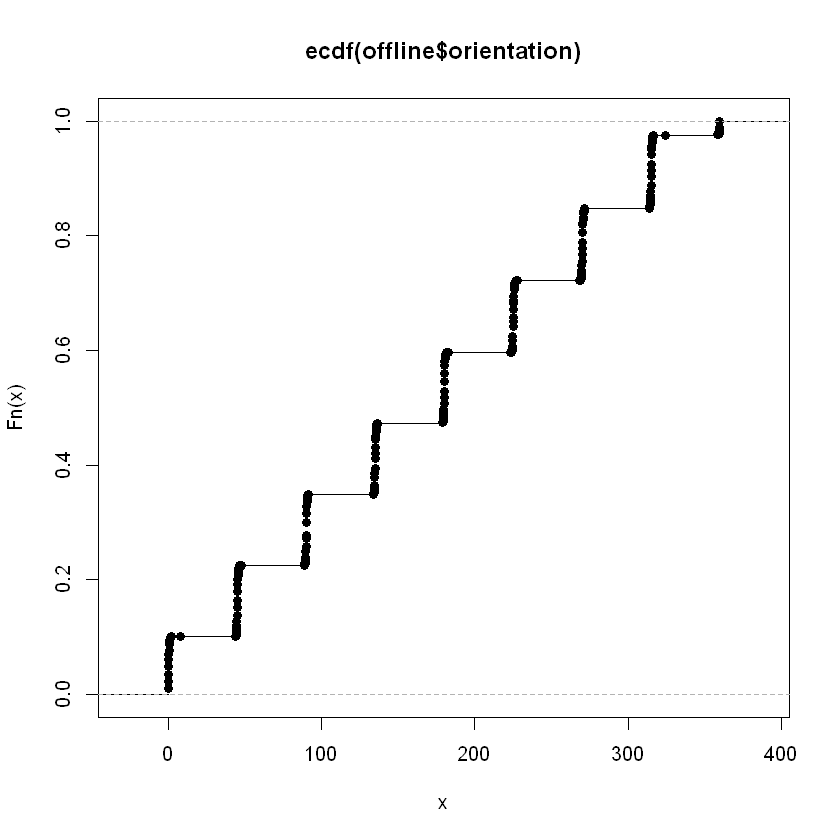

In [26]:
# Per documentation, should have 8 values for orientation (0, 45, 90,..., 315)
length(unique(offline$orientation))

# At 203, this is not the case. Examine the distribution of orientation
plot(ecdf(offline$orientation))


Figure 1.2: Empirical CDF of Orientation for the Hand-Held Device. Shows 8 basic orientations that are 45 degrees apart.

Although the experiment was designed to measure signal strength at 8 orientations - 45 degree intervals from 0 to 315 - these orientations are not exact. However, it may be useful to work with values corresponding to the 8 equi-spaced angles, i.e. map 47.5 to 45, and 358.2 to 0, and so on. To do this, take each value and find out which of the 8 orientations is closest and that orientation. Pay special attention to values such as 358.2, as they should map to 0, not to the closer 315.

In [27]:
# Use roundOrientation() to create the rounded angles, from notes above

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}


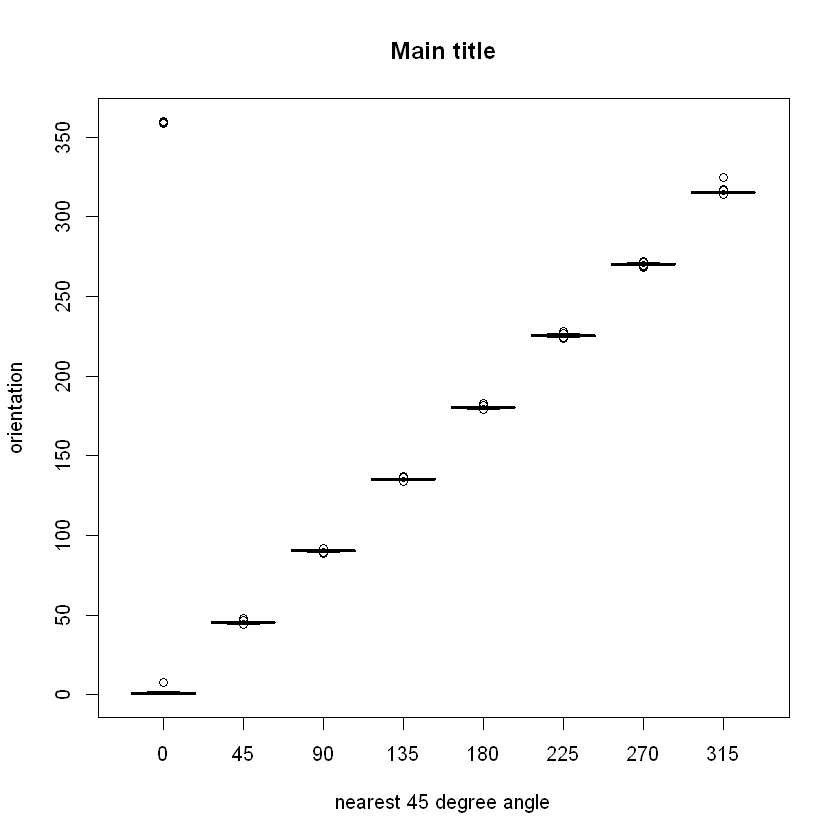

In [28]:
# Create rounded angles and check boxplots
offline$angle = roundOrientation(offline$orientation)

with(offline, boxplot(orientation ~ angle,
                     xlab = "nearest 45 degree angle",
                     ylab = "orientation",
                     main="Main title"))


Figure 1.3: Boxplots of Orientation for the Hand-Held Device. Confirm that values have mapped correctly.

### 1.3.2 EXPLORE MAC ADDRESSES

In [29]:
# From the summary() information, there may be a one-to-one mapping between MAC address of the access points and channel. 
# For example, the summary statistics show 126,529 occurrences of the address 00:14:bf:3b:c7:c6 and the same number of 
# occurrences of channel 2432000000.

# To check for 1:1 mapping, look at relationship between MAC address and channel. The unique addresses and channels should
# be the same number if 1:1.
c(length(unique(offline$mac)), length(unique(offline$channel)))


[1] 12  8

First and last two MAC addresses are not near the testing area or were only working/active for a short time  during the measurement process because their counts are very low. 
 
Also likely that third and fifth addresses are not among the access points displayed because they have much lower counts.


In [30]:
# Results -  12 MAC addresses and 8 channels.
# Building plan (figure 1.1) indcates 6 access points. Documentation notes there are additional access points that 
# are not part of the testing area, so not seen on the floor plan.
# Check counts of observations for the various MAC addresses
table(offline$mac)



00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

In [31]:
# First and last two MAC addresses are not near the testing area or were only working/active for a short time 
# during the measurement process because their counts are very low. 
# Also likely that third and fifth addresses are not among the access points displayed because they have much lower counts.
# Possible 146,080 recordings total (recall that there are potentially signals recorded at 166 grid points, 8 orientations,
# and 110 replications).

# Per documentation, access points consist of 5 Linksys/Cisco and one Lancom L-54g routers. 
# Look up MAC addresses to find the vendor addresses: 00:14:bf -- Linksys, 00:0f:a3 -- Alpha Networks, and 
# 00:a0:57 -- Lancom devices.
# 5 devices with an address that begins are Linksys; none from Lancom (conflict with documentation)
# For now, keep the records from top 7 devices.
subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]


In [32]:
# Create table of counts for the remaining MAC × channel combination, confirm there is one non-zero entry in each row.
macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

# There is 1:1 correspondence between MAC address and channel for 7 devices. Eliminate channel from offline.

offline = offline[ , "channel" != names(offline)]


00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

### 1.3.3 EXPLORE HAND-HELD DEVICE

In [33]:
# Tally number of rows in data frame for each unique (x, y) combination.

locDF <- with(offline, by(offline, list(posX, posY), function(x) x))

# Check
length(locDF)


[1] 476

In [34]:
# 476 is longer than number of combinations of actual (x, y) locations at which measurements were recorded.
# Many of these elements are empty.

sum(sapply(locDF, is.null))

[1] 310

In [35]:
# Null values correspond to combinations of the xs and ys that were not observed. Drop unneeded elements.
locDF <- locDF[!sapply(locDF, is.null)]

# Check/Confirm only 166 locations
length(locDF)


[1] 166

In [36]:
# Determine the number of observations recorded at each location.
locCounts <- sapply(locDF, nrow)

# Keep position information with lcoation. 
locCounts <- sapply(locDF, function(df) c(df[1, c("posX", "posY")], count = nrow(df)))

# Confirm matrix matrix strucutre
class(locCounts)

[1] "matrix"

In [37]:
# Confirm 3 rows
dim(locCounts)

[1]   3 166

In [38]:
# Examine a few counts
locCounts[, 1:8]

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
posX  0    1    2    0    1    2    0    1   
posY  0    0    0    1    1    1    2    2   
count 5505 5505 5506 5524 5543 5558 5503 5564

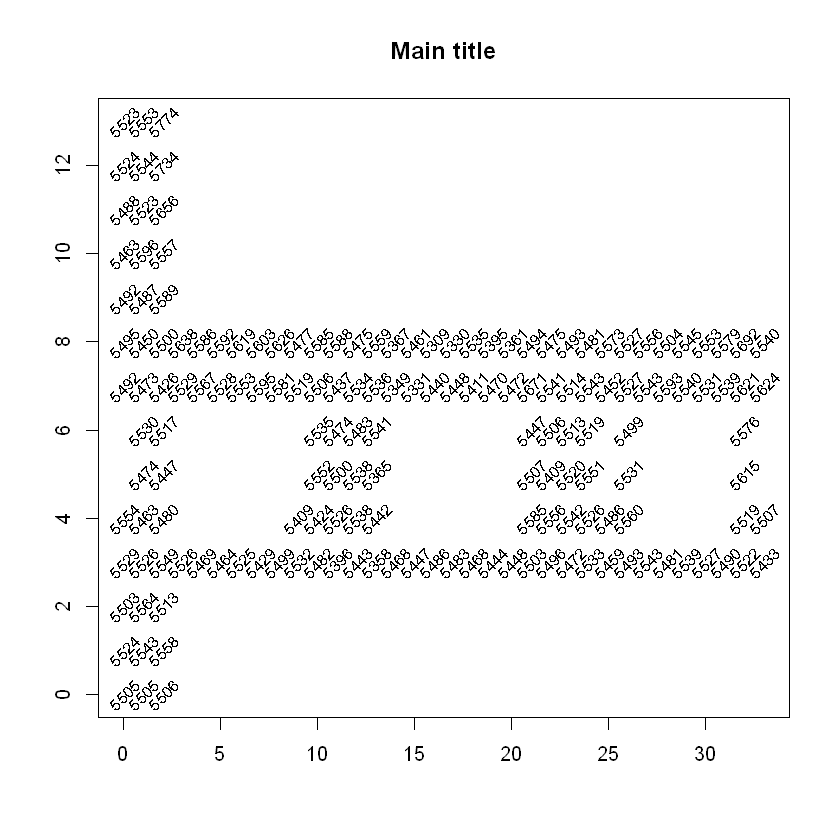

In [39]:
# There are roughly 5,500 recordings at each position, which aligns with 8 orientations × 110 replications × 7 access points,
# which is 6,160 signal strength measurements. Visualize all 166 counts by adding the counts as text at respective locations.
# Transpose matrix so locations are columns of matrix and change size/angle of characters to plot.
locCounts = t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "", main="Main title")
text(locCounts, labels = locCounts[, 3], cex = 0.8, srt = 45)


Figure 1.5: Counts of Signals at Each Position. Ideally 110 signals measured at 8 angles for 6 access pooints, for a total of 5,280. Data includes 7th MAC address and not all signals detected, resulting in approximately 5,500 reading at each location.

### 1.3.4 CREATE A FUNCTION TO PREPARE DATA -- NEED HELP HERE

MAY NOT NEED THIS SECTION

'We have examined all the variables except time and signal. This process has helped us
clean our data and reduce it to those records that are relevant to our analysis. We leave the
examination of the signals to the next section where we study its distributional properties.
As for time, while this variable is not directly related to our model, it indicates the order
in which the observations were taken. In an experiment, this can be helpful in uncovering
potential sources of bias. For example, the person carrying the hand-held device may have
changed how the device was carried as the experiment progressed and this change may lead
to a change in the strength of the signal. Plots and analyses of the relationship between time
and other variables can help us uncover such potential problems. We leave this investigation
as an exercise.
Since we also want to read the online data in R, we turn all of these commands into
a function called readData(). Additionally, if we later change our mind as to how we want
to handle some of these special cases, e.g., to keep channel or posZ, then we can make a
simple update to our function and rerun it. We might even add a parameter to the function
definition to allow us to process the data in different ways. We leave it as an exercise to
create readData().

#### We call readData() to create the offline data frame with'

readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
    # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)
    
    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
    
    return(offline)
  }

offlineRedo = readData()

Then we use the identical() function to check this version of the data frame against the one that we already created:

library(codetools)

identical(offline, offlineRedo)

findGlobals(readData, merge = FALSE)$variables

### 1.4.1 Distribution of Signal Strength

In [40]:
# Load packages needed
library(codetools)
library(lattice)


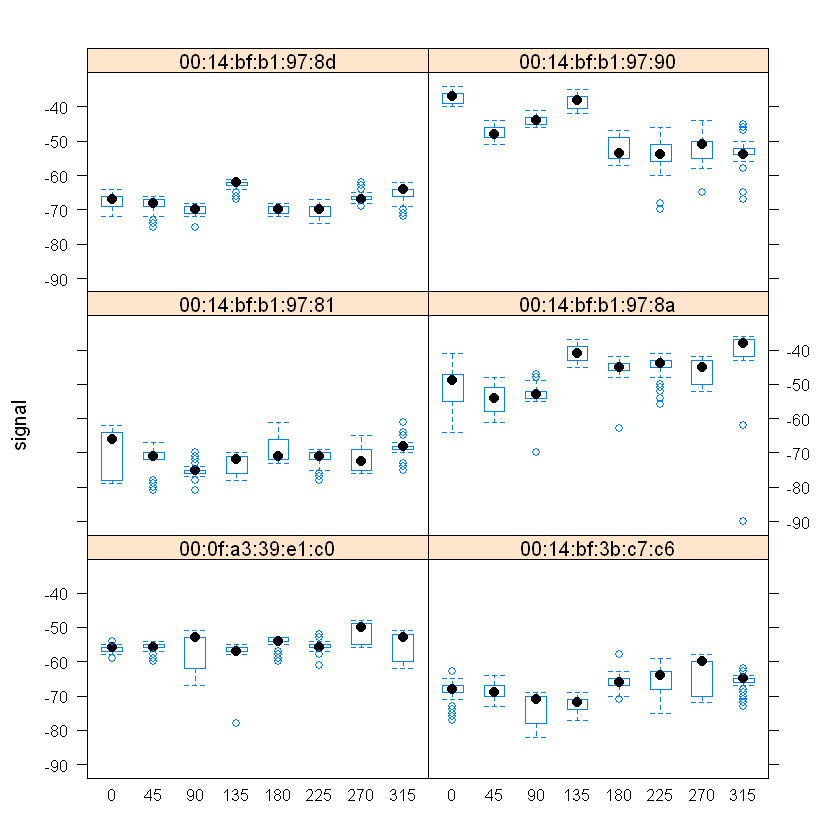

In [41]:
# Compare distribution of signal strength at different orientations and for different access points.
# Subdivide data. COnsider impact of orientation on signal strength by fixing a location on the map to see how the signal changes as the experimenter forates through 8 angles. 
# Examine MAC addresses because at an orientation of 90 degress the experimentater mgith be facing toward on access point and away from another. 

bwplot(signal ~ factor(angle) | mac, data = offline, subset = posX == 2 & posY == 
    12 & mac != "00:0f:a3:39:dd:cd", layout = c(2, 3))

See that Signal Strength varies with orientation for both close and distant access points. 
Dropped MAC address 00:0f: - a3:39:dd:cd

In [42]:
# Signal Strength is measured as negative values. 

summary(offline$signal)

# Small values correspond to weak signals and large values are strong. 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

null device 
          1

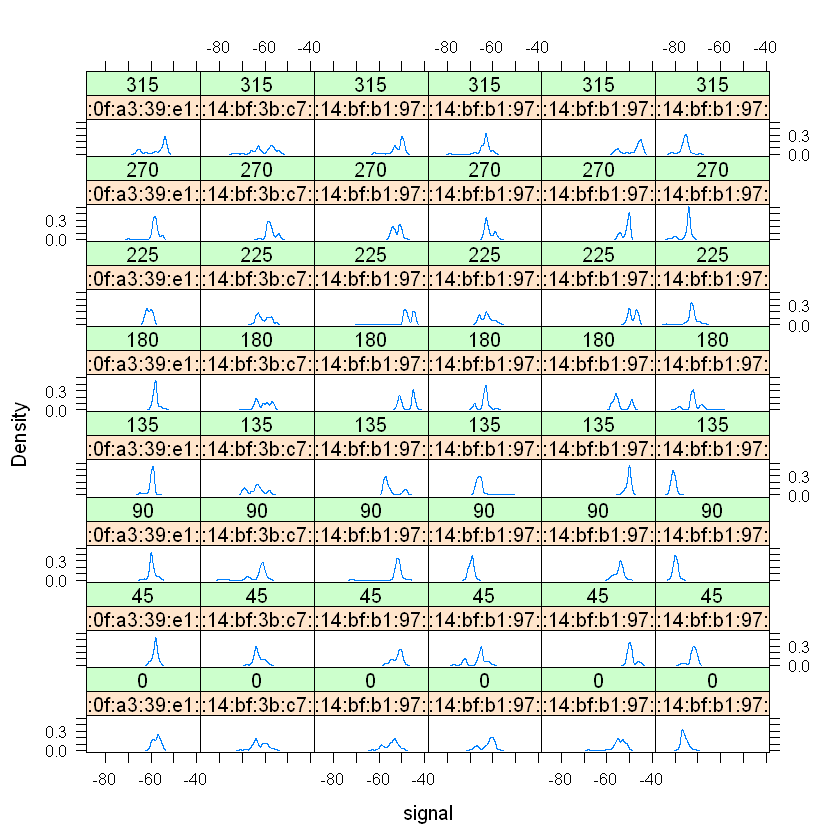

In [43]:
# Find a similar dependence of signal strength on angle. Produce 48 density curves for one location.

#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot(~signal | mac + factor(angle), data = offline, subset = posX == 
    24 & posY == 4 & mac != "00:0f:a3:39:dd:cd", bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

Many distributions look approximately normal. Although there are some serious departures with secondary modes and and skewness. The center of the distribution varies with angle and MAC address, so conditioning on angle and MAC address is warranted. 

In [44]:
# Examine summary statistics of mean and SD or media and IQR of signal strength for all location-orientation-access point combinations. 

offline$posXY <- paste(offline$posX, offline$posY, sep = "-")

In [45]:
write.csv(offline,"C:/Users/jjschued/Documents/SMU/7333 QTW/offline.csv", row.names = TRUE)

In [46]:
# Create list of data frames for every combination of (x, y), angle, and access point

byLocAngleAP <- with(offline, by(offline, list(posXY, angle, mac), function(x) x))

In [47]:
length(offline[offline$posXY == '0-1',])

[1] 9

In [152]:
# Calculate summary stats for each data frame

signalSummary = lapply(byLocAngleAP, function(oneLoc) {
    ans = oneLoc[1, ]
    ans$medSignal = median(oneLoc$signal)
    ans$avgSignal = mean(oneLoc$signal)
    ans$num = length(oneLoc$signal)
    ans$sdSignal = sd(oneLoc$signal)
    ans$iqrSignal = IQR(oneLoc$signal)
    ans
})

offlineSummary = do.call("rbind", signalSummary)

In [156]:
head(offlineSummary)

time                posX posY orientation mac               signal
7      2006-02-11 01:31:58 0     0   0.0         00:0f:a3:39:dd:cd -75   
24512  2006-02-11 02:03:44 0     1   0.7         00:0f:a3:39:dd:cd -73   
221777 2006-02-11 05:46:02 0    10   0.9         00:0f:a3:39:dd:cd -69   
229191 2006-02-11 05:54:05 0    11   0.4         00:0f:a3:39:dd:cd -72   
236493 2006-02-11 06:02:32 0    12   0.2         00:0f:a3:39:dd:cd -72   
243546 2006-02-11 06:14:12 0    13   0.1         00:0f:a3:39:dd:cd -69   
       rawTime angle posXY medSignal avgSignal num sdSignal iqrSignal
7      1.1e+12 0     0-0   -67       -68       111 3.2      4.5      
24512  1.1e+12 0     0-1   -70       -70       110 2.4      3.0      
221777 1.1e+12 0     0-10  -67       -69       111 4.4      6.5      
229191 1.1e+12 0     0-11  -73       -74       111 5.4      7.0      
236493 1.1e+12 0     0-12  -70       -70       114 2.4      3.0      
243546 1.1e+12 0     0-13  -74       -74       109 3.5      4.0

null device 
          1

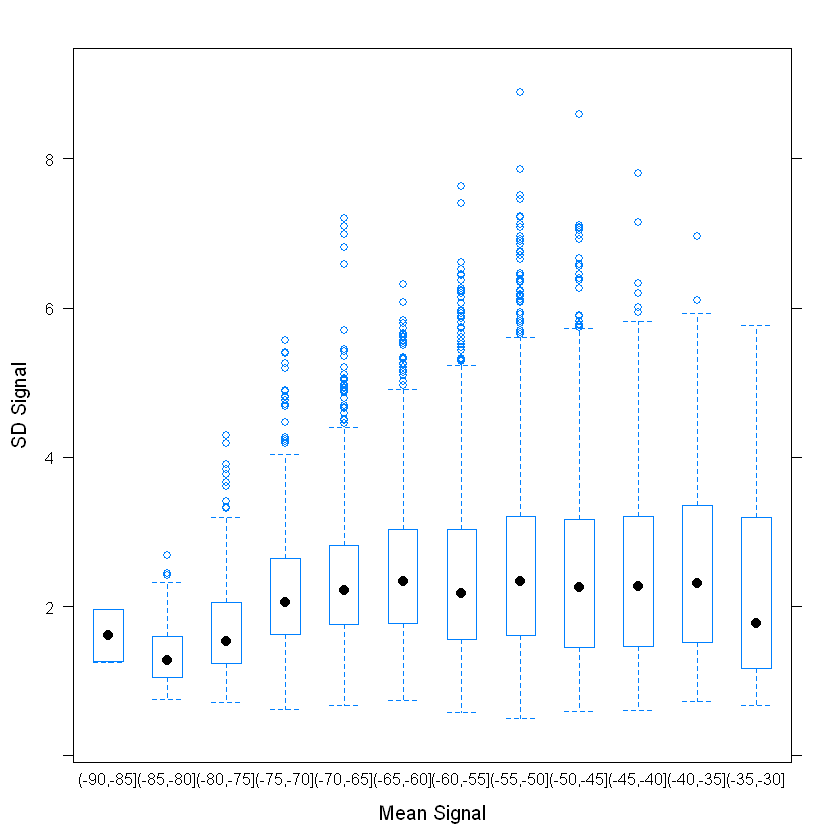

In [49]:
# Examine standard, see if they vary by average signal strength. Make box plots of sdSignal for subgroups of avgSignal by turning avgSignal into categorial variable. 

#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

See that weakest signals have small standard deviations and it appears that SD increase with average signal strength.

See that these two measures of centrailty are similar to each other; they typically differ by less than 1 or 2 dBm.

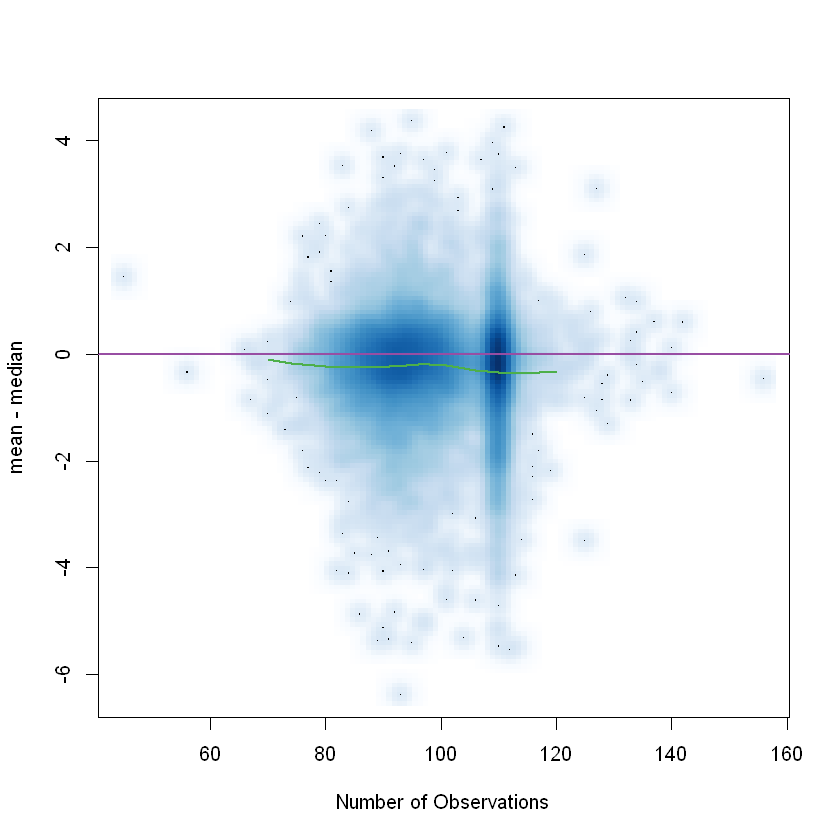

In [50]:
# Examine skewness of signal strength by plotting difference avgSignal - medSignal against observations. 
# Smooth scatter avoids problems with over plotting; add local average of difference between mean and median to better assess size. 

with(offlineSummary, smoothScatter((avgSignal - medSignal) ~ num, xlab = "Number of Observations", 
    ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

# Use loess() to locally smooth differences between mean and median.

lo.obj = with(offlineSummary, loess(diff ~ num, data = data.frame(diff = (avgSignal - 
    medSignal), num = num)))

# Then use fitted model to predict the idffernce for each value of num and add those to scatter plot.
lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

## Relationship between Signal and Distance
 Examine relationship between distance and signal strength is to smooth signal strength over the region where it is measured and create a contour plot -- portion of floor plan where there is strong signal corresponds to mountainous regions on map. 

In [51]:
#install.packages("fields")
library(fields)

Warning message:
"package 'fields' was built under R version 3.6.3"Loading required package: spam
Warning message:
"package 'spam' was built under R version 3.6.3"Loading required package: dotCall64
Warning message:
"package 'dotCall64' was built under R version 3.6.3"Loading required package: grid
Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


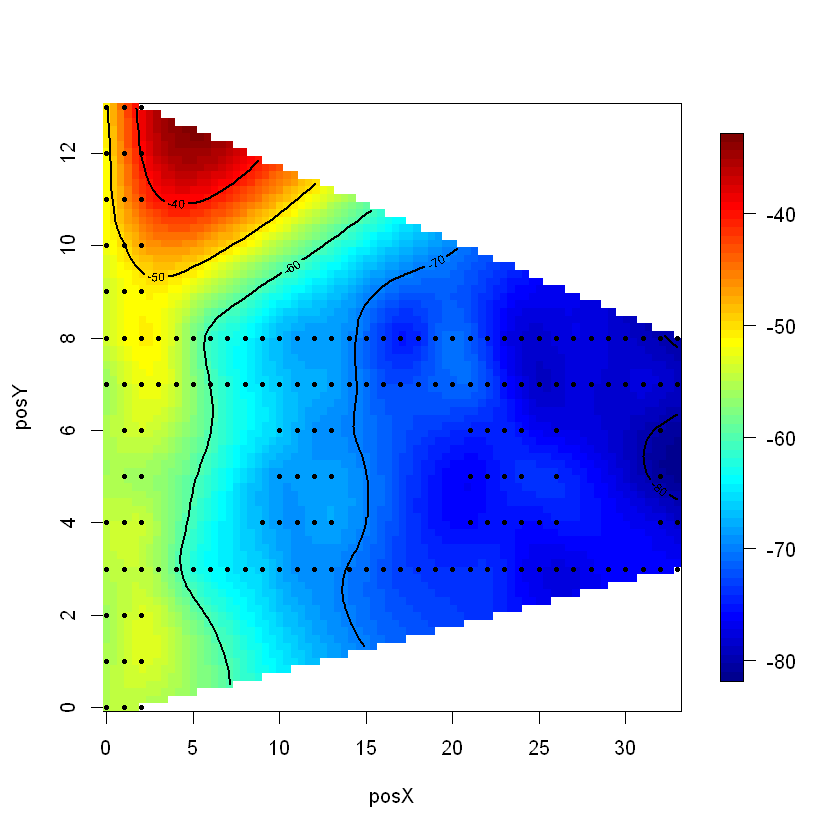

In [52]:
# Select one MAC address and one orientation. Choose summary stats for an angle x MAC combination
oneAPAngle <- subset(offline, mac == subMacs[5] & angle == 0)

# Make topographical map, using fields package. Uses the method of thin plate splines to fit a surface to the signal stregnth values at the observed locations. 
# Tps() requres a "z" value, so must subset offLine Summary
oneAPAngle = subset(offlineSummary, mac == subMacs[5] & angle == 0)

# Call Tps() to fit a smooth surface to mean signal strength 
smoothSS = Tps(oneAPAngle[, c("posX", "posY")], oneAPAngle$avgSignal)

# Use predictSurface() to predict the value for the fitted surface at a grid of the observed posX and posY 
vizSmooth = predictSurface(smoothSS)

#Plot predicted signal strength using plot.surface()
plot.surface(vizSmooth, type = "C")

# Lastly add locations where measurements were taken
points(oneAPAngle$posX, oneAPAngle$posY, pch = 19, cex = 0.5)

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

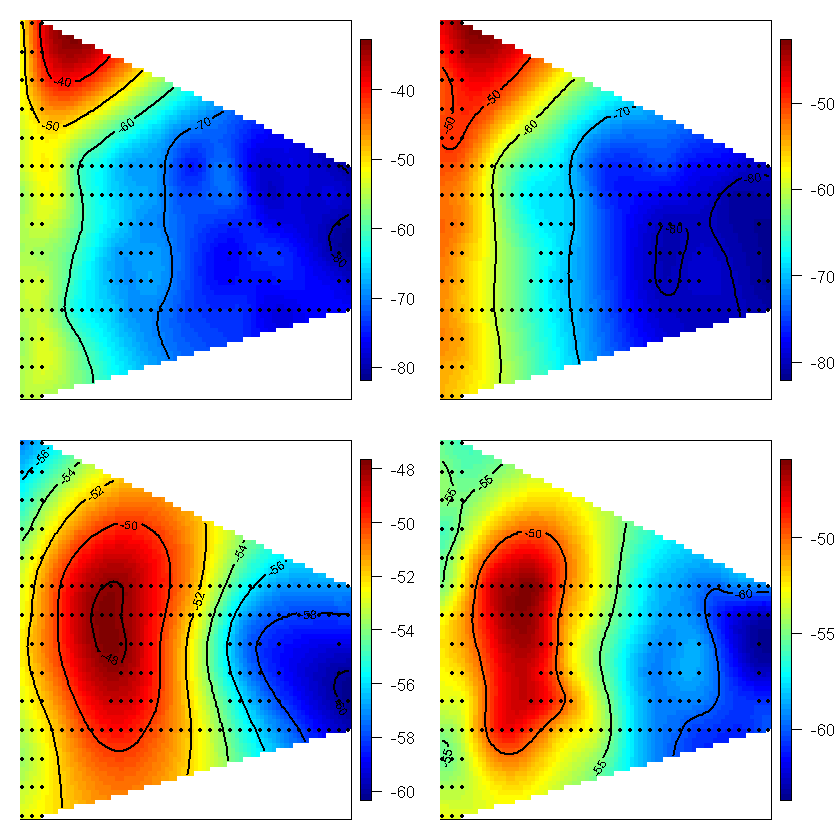

In [53]:
# Wrap plotting routine into own function so that we can parameterize the MAC address and angle, other other plotting parameters. 
# surfaceSS() has 3 args - data, MAC, angle
# call surfaceSS() with a couple MAC addresses and angles to compare. Modify R plotting parameters to place 4 contour plots on one canvas. 

surfaceSS = function(data, mac, angle = 45) {
    require(fields)
    oneAPAngle = data[data$mac == mac & data$angle == angle, ]
    smoothSS = Tps(oneAPAngle[, c("posX", "posY")], oneAPAngle$avgSignal)
    vizSmooth = predictSurface(smoothSS)
    plot.surface(vizSmooth, type = "C", xlab = "", ylab = "", xaxt = "n", yaxt = "n")
    points(oneAPAngle$posX, oneAPAngle$posY, pch = 19, cex = 0.5)
}

# Save Current Settings
parCur = par(mfrow = c(2, 2), mar = rep(1, 4))

# Mak 4 calls to surfaceSS() using mapply()
mapply(surfaceSS, mac = subMacs[rep(c(5, 1), each = 2)], angle = rep(c(0, 135), 
    2), data = list(data = offlineSummary))

Above, identify the location of access points as the dark red region. We can also confirm the effect of orientation on signal strength. A corridor effect emerges - the signal is stronger relative to distance along ocorridors where the signals are not blocked by walls. 

In [54]:
# We find that two MAC addresses have similiar heat maps; these correspond to access points near center of building (i.e. x=7.5, y=6.3)
# Choose first of these.

offlineSummary <- subset(offlineSummary, mac != subMacs[2])

In [157]:
# Create small matrix with relevant positions for the 6 access points on floor plan.

AP <- matrix(c(7.5, 6.3, 2.5, -0.8, 12.8, -2.8, 1, 14, 33.5, 9.3, 33.5, 2.8), 
    ncol = 2, byrow = TRUE, dimnames = list(subMacs[-2], c("x", "y")))

AP

x    y   
00:0f:a3:39:e1:c0  7.5  6.3
00:14:bf:3b:c7:c6  2.5 -0.8
00:14:bf:b1:97:90 12.8 -2.8
00:14:bf:b1:97:8d  1.0 14.0
00:14:bf:b1:97:81 33.5  9.3
00:0f:a3:39:dd:cd 33.5  2.8

In [158]:
# To examine relationship between signal strength and distance from the access point, compute distances from locations of device emitting signal to the access point receiving signal.
# First compute difference between x coorindate and acces point x coordiante; then for y coordinates.

diffs <- offlineSummary[, c("posX", "posY")] - AP[offlineSummary$mac, ]

ERROR: Error in AP[offlineSummary$mac, ]: subscript out of bounds


In [159]:
# Use differnces to find Euclidean distance between position of hand-held device and access point.

offlineSummary$dist <- sqrt(diffs[, 1]^2 + diffs[, 2]^2)

ERROR: Error in `$<-.data.frame`(`*tmp*`, dist, value = c(9.7948966303887, 9.18368117913509, : replacement has 7968 rows, data has 9296


Appears to be curvature to plots. A log transform might improve relationship; but signals are negative so need to be cautious. 

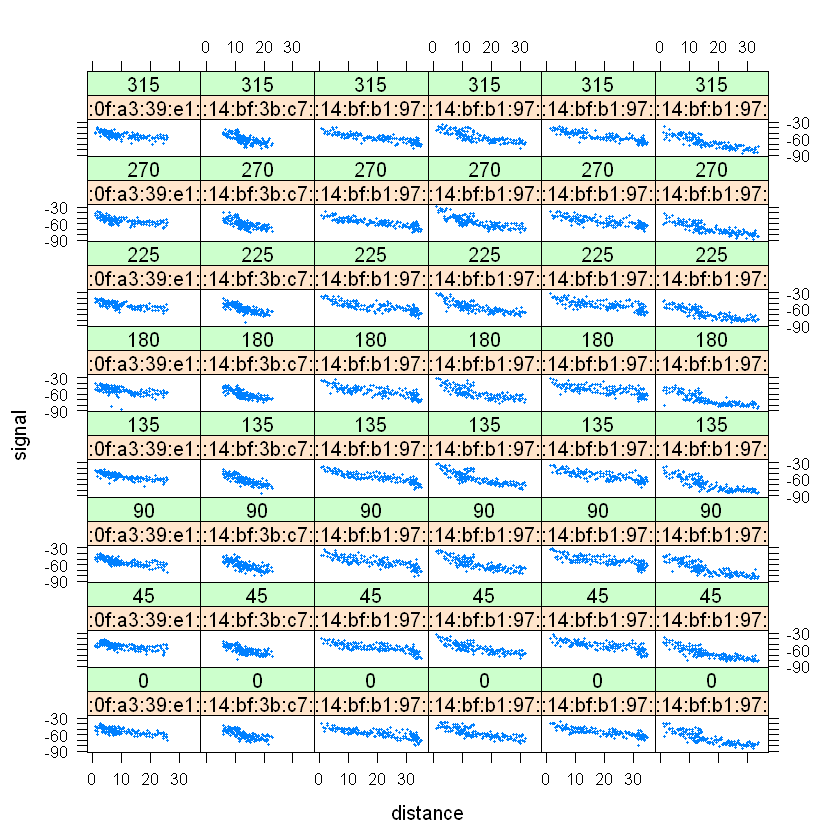

In [58]:
# Make series of scatter plots for access point and device orientation. 

xyplot(signal ~ dist | factor(mac) + factor(angle), data = offlineSummary, pch = 19, 
    cex = 0.3, xlab = "distance")

## 1.5 Nearest Neighbor Methods to Predict Location

#### Numerous statistical techniques to estimate location of device from signal strength between device and several access points. Here, using simple and intuitive k-NN: have training data where signal is measured to several access points from known position throughout building; when get a new observation (new set of signal strengths from unknown location), find observation in training data that is close to new observation. 

### 1.5.1 Preparing Test Data
#### Online data are in online.final.trace.txt; use readData() from Section 1.2 to process raw data. 

In [42]:
macs <- unique(offlineSummary$mac)

In [137]:
# edited to match book
#online <- readLines("C:/Users/jjschued/Documents/SMU/7333 QTW//online.final.trace.txt", subMacs = macs)

# Joe's code; SEE REMAINDER OF CODE BELOW
online <- readLines("C:/Users/jjschued/Documents/SMU/7333 QTW//online.final.trace.txt")
    # subMacs = macs)

onlines = online[ substr(online, 1, 1) != "#" ]
tmp = lapply(onlines, processLine)
online = as.data.frame(do.call("rbind", tmp),stringsAsFactors = FALSE)


names(online) = c("time", "scanMac", "posX", "posY", "posZ", "orientation", 
        "mac", "signal", "channel", "type")

roundOrientation = function(angles) {
    refs = seq(0, by = 45, length = 9)
    q = sapply(angles, function(o) which.min(abs(o - refs)))
    c(refs[1:8], 0)[q]
}
# keep only signals from access points
online = online[online$type == "3", ]
               
            

# drop scanMac, posZ, channel, and type - no info in them
dropVars = c("scanMac", "posZ", "channel", "type")
online = online[, !(names(online) %in% dropVars)]

# convert numeric values
numVars = c("time", "posX", "posY", "orientation", "signal")
online[numVars] = lapply(online[numVars], as.numeric)


# drop more unwanted access points
subMacs = c("00:0f:a3:39:e1:c0", "00:14:bf:b1:97:8a",
        "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d", "00:14:bf:b1:97:81", "00:0f:a3:39:dd:cd")               
online = online[online$mac %in% subMacs, ]
               
# convert time to POSIX
online$rawTime = online$time
online$time = online$time/1000
class(online$time) = c("POSIXt", "POSIXct")
    
# round orientations to nearest 45
online$angle = roundOrientation(online$orientation)
# Create unique location identifier
online$posXY <- paste(online$posX, online$posY, sep = "-")
macs <-unique(online$mac)
macs   
length(unique(online$posXY))               

[1] "00:14:bf:b1:97:8a" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"
[7] "00:0f:a3:39:dd:cd"

[1] 60

In [138]:
subMacs

[1] "00:0f:a3:39:e1:c0" "00:14:bf:b1:97:8a" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:90" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:81"
[7] "00:0f:a3:39:dd:cd"

In [139]:
online2 = online[online$mac %in% subMacs, ]

In [140]:
unique(online$mac)

[1] "00:14:bf:b1:97:8a" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"
[7] "00:0f:a3:39:dd:cd"

In [141]:
unique(online2$mac)

[1] "00:14:bf:b1:97:8a" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"
[7] "00:0f:a3:39:dd:cd"

In [142]:
# Use new variable to determine that we have 60 unique test locations

length(unique(online$posXY))

[1] 60

In [143]:
# Tally number of signal strengths recorded at each location

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

# Output indicates that signal strengths were recorded at one orientation for each location

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 704   0   0   0   0
  0.15-9.42    0   0 717   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 684   0   0
  0.47-8.2   701   0   0   0   0   0   0   0
  0.78-10.94 695   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 691   0   0   0

In [144]:
# Organize data in different structure; organize data into 6 columns of signal strengths
# Summarize online data into new format, providing average signal strength at each location

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7,
                             dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  


In [145]:
# New Frame should have 60 rows and 11 variables, including 6 average signal strengths at the corresponding MAC addresses

dim(onlineSummary)

[1] 60 12

In [146]:
# Confirm

names(onlineSummary)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [147]:
head(onlineSummary)

posXY      posX posY  orientation angle 00:0f:a3:39:dd:cd
0-0.05     0-0.05     0.00  0.05 130.5       135   -63              
0.15-9.42  0.15-9.42  0.15  9.42 112.3        90   -66              
0.31-11.09 0.31-11.09 0.31 11.09 230.1       225   -67              
0.47-8.2   0.47-8.2   0.47  8.20   5.8         0   -74              
0.78-10.94 0.78-10.94 0.78 10.94 348.3         0   -71              
0.93-11.69 0.93-11.69 0.93 11.69 158.3       180   -70              
           00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0.05     -52               -63               -62              
0.15-9.42  -55               -74               -73              
0.31-11.09 -52               -70               -70              
0.47-8.2   -50               -64               -73              
0.78-10.94 -53               -67               -67              
0.93-11.69 -58               -70               -71              
           00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0.05     -40               -63               -55              
0.15-9.42  -48               -69               -47              
0.31-11.09 -54               -69               -54              
0.47-8.2   -46               -61               -50              
0.78-10.94 -48               -65               -55              
0.93-11.69 -44               -66               -47

In [149]:
write.csv(onlineSummary,"C:/Users/jjschued/Documents/SMU/7333 QTW/onlinewithcd.csv", row.names = TRUE)

### 1.5.2 Choice of Orientation
#### Find records in offline data that have similar orientations to our new observations. This helps calculated the nears neighbor by using known point with similar signal strength. As we saw from above, orientation impact signal strength 

In [85]:
# m for the number of angles and angleNewObs the angle of new observation. Find angles to include.

m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)

if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}


In [86]:
# Handle case of m odd and even separately; must also map angles to values in refs, -45 to 355 and 405 maps to 45. So adjust angles:

angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360


In [87]:
# Select observations from offlineSummary to analyze

offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]


In [164]:
head(offlineSummary)

time                posX posY orientation mac               signal
7      2006-02-11 01:31:58 0     0   0.0         00:0f:a3:39:dd:cd -75   
24512  2006-02-11 02:03:44 0     1   0.7         00:0f:a3:39:dd:cd -73   
221777 2006-02-11 05:46:02 0    10   0.9         00:0f:a3:39:dd:cd -69   
229191 2006-02-11 05:54:05 0    11   0.4         00:0f:a3:39:dd:cd -72   
236493 2006-02-11 06:02:32 0    12   0.2         00:0f:a3:39:dd:cd -72   
243546 2006-02-11 06:14:12 0    13   0.1         00:0f:a3:39:dd:cd -69   
       rawTime angle posXY medSignal avgSignal num sdSignal iqrSignal
7      1.1e+12 0     0-0   -67       -68       111 3.2      4.5      
24512  1.1e+12 0     0-1   -70       -70       110 2.4      3.0      
221777 1.1e+12 0     0-10  -67       -69       111 4.4      6.5      
229191 1.1e+12 0     0-11  -73       -74       111 5.4      7.0      
236493 1.1e+12 0     0-12  -70       -70       114 2.4      3.0      
243546 1.1e+12 0     0-13  -74       -74       109 3.5      4.0

In [169]:
# Aggregate signal strengths from angles and create data structure that is similar to onlineSummary
# Use helper function reshapeSS()

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY","orientation", "angle")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))
  
  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}


In [170]:
# Summarize and Reshape offlineSubset (Set Training Set)

#trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")
trainofflinecdss = reshapeSS(offlineSummary, varSignal = "avgSignal")

In [172]:
write.csv(trainofflinecdss,"C:/Users/jjschued/Documents/SMU/7333 QTW/trainofflinecdss.csv", row.names = TRUE)

In [171]:
head(trainofflinecdss)

posXY posX posY orientation angle 00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0
0-0  0-0   0     0   0.0         0     -70               -53              
0-1  0-1   0     1   0.7         0     -71               -53              
0-10 0-10  0    10   0.9         0     -69               -55              
0-11 0-11  0    11   0.4         0     -71               -54              
0-12 0-12  0    12   0.2         0     -69               -54              
0-13 0-13  0    13   0.1         0     -73               -55              
     00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 00:14:bf:b1:97:8d
0-0  -66               -65               -39               -66              
0-1  -66               -66               -40               -66              
0-10 -65               -66               -45               -66              
0-11 -68               -69               -48               -67              
0-12 -68               -71               -46               -68              
0-13 -71               -72               -45               -69              
     00:14:bf:b1:97:90
0-0  -56              
0-1  -58              
0-10 -52              
0-11 -55              
0-12 -53              
0-13 -55

In [167]:
length(offlineSubset)

[1] 15

In [91]:
# Wrap code to select angles and call to reshapeSS() into function called selectTrain()
# selectTrain() has 3 args: angleNewObs, angle of new observation; singals, the training data/data in format of offlineSummary; m, number of angles to include form signals.
# Returns data frame that matches trainSS

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}


In [92]:
# Test function for angle of 130 and m of 3; aggregate offline data angles of 90, 135, 180
train130 = selectTrain(130, offlineSummary, m = 3)

# Reformatted results for readability
head(train130)


posXY posX posY 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   -52               -66               -63              
0-1  0-1   0     1   -53               -65               -64              
0-10 0-10  0    10   -56               -66               -69              
0-11 0-11  0    11   -55               -67               -70              
0-12 0-12  0    12   -56               -70               -72              
0-13 0-13  0    13   -55               -71               -73              
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -36               -64               -55              
0-1  -39               -65               -59              
0-10 -45               -67               -50              
0-11 -48               -67               -55              
0-12 -45               -67               -50              
0-13 -43               -69               -54

In [93]:
# selectTrain() averages signal strength for different angles to produce one set of signal strengths for each 166 location in training data
length(train130[[1]])

[1] 166

In [94]:
# May not want to collapse signal strengths across m angles and instead return a set of mX166 signals
# Try alternative approach

### 1.5.3 Finding the Nearest Neighbors
#### have training data to use to predict location of new points; look at distance in terms of signal strengths from these training data to new point. 

In [95]:
m <- 3
angleNewObs <- 230
refs <- seq(0, by = 45, length = 8)
nearestAngle <- roundOrientation(angleNewObs)

if (m%%2 == 1) {
    angles = seq(-45 * (m - 1)/2, 45 * (m - 1)/2, length = m)
} else {
    m = m + 1
    angles = seq(-45 * (m - 1)/2, 45 * (m - 1)/2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
        angles = angles[-1] else angles = angles[-m]
}

## m odd and even are handled seperatly. Map angles to refs Adjustments
angles <- angles + nearestAngle
angles[angles < 0] = angles[angles < 0] + 360
angles[angles > 360] = angles[angles > 360] - 360

In [96]:
offlineSubset <- offlineSummary[offlineSummary$angle %in% angles, ]

In [97]:
reshapeSS <- function(data, varSignal = "signal", keepVars = c("posXY", "posX", 
    "posY")) {
    byLocation <- with(data, by(data, list(posXY), function(x) {
        ans = x[1, keepVars]
        avgSS = tapply(x[, varSignal], x$mac, mean)
        y = matrix(avgSS, nrow = 1, ncol = 6, dimnames = list(ans$posXY, names(avgSS)))
        cbind(ans, y)
    }))
    
    newDataSS <- do.call("rbind", byLocation)
    return(newDataSS)
}

In [98]:
trainSS <- reshapeSS(offlineSubset, varSignal = "avgSignal")

In [99]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1) {
    # m is the number of angles to keep between 1 and 5
    refs = seq(0, by = 45, length = 8)
    nearestAngle = roundOrientation(angleNewObs)
    
    if (m%%2 == 1) 
        angles = seq(-45 * (m - 1)/2, 45 * (m - 1)/2, length = m) else {
        m = m + 1
        angles = seq(-45 * (m - 1)/2, 45 * (m - 1)/2, length = m)
        if (sign(angleNewObs - nearestAngle) > -1) 
            angles = angles[-1] else angles = angles[-m]
    }
    angles = angles + nearestAngle
    angles[angles < 0] = angles[angles < 0] + 360
    angles[angles > 360] = angles[angles > 360] - 360
    angles = sort(angles)
    
    offlineSubset = signals[signals$angle %in% angles, ]
    reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [100]:
train130 <- selectTrain(130, offlineSummary, m = 3)
head(train130)

posXY posX posY 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   -52               -66               -63              
0-1  0-1   0     1   -53               -65               -64              
0-10 0-10  0    10   -56               -66               -69              
0-11 0-11  0    11   -55               -67               -70              
0-12 0-12  0    12   -56               -70               -72              
0-13 0-13  0    13   -55               -71               -73              
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -36               -64               -55              
0-1  -39               -65               -59              
0-10 -45               -67               -50              
0-11 -48               -67               -55              
0-12 -45               -67               -50              
0-13 -43               -69               -54

In [150]:
trainSubset

ERROR: Error in eval(expr, envir, enclos): object 'trainSubset' not found


In [101]:
# Use findNN() to calcluate distance from new point to all observations in training set
# Parameters are numeric vector of 6 new signal strengths and the return value from selectTrain()
# Returns locations of training observations in order of closeness to new observation's signal strength

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}


In [102]:
# Two functions, trainSelect() and findNN(), to provide locations in trainig data that have signals strengths close to test obsercvation.
# Formalize approach to make predictions for all test data, with predXY()
predXY <- function(newSignals, newAngles, trainData, numAngles = 1, k = 5) {
    
    closeXY = list(length = nrow(newSignals))
    
    for (i in 1:nrow(newSignals)) {
        trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
        closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
    }
    
    estXY = lapply(closeXY, function(x) sapply(x[, 2:3], function(x) mean(x[1:k])))
    estXY = do.call("rbind", estXY)
    return(estXY)
}

### 1.5.4 Cross-Validation and Choice of k
#### Choice of k - number of neighbors to include in estimate of new observation's position - is a model select problem. Cross validation can help here. 

In [103]:
# Use all 8 orientations and 6 MAC addresses with each location
# Cross Validate on 166 locations
# try v = 11, each fold has floor(166/v), or 15 locations

v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

# Warning message with matrix() because v doesn't divide evenly into 166, so permuteLocs doesn't have all 166 locations.

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"

In [104]:
# Summarize data so data structure matches online Summary, includes selecting an orientation at random because each test observation has only 1 orientation
# Online data has structure that had 6 columns of signal strength, one for each access point
# Create test data from offline and divide into folds, augment reshapeSS()

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))
  
  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}


In [112]:
# Summarize and format offline (after revising reshapeSS() and augmenting with sampleAngle with default = FALSE)

offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

In [106]:
# First fold
onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

In [109]:
onlineCVSummary

posXY posX posY orientation angle 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6
0-0  0-0    0    0   270.1       270   -55               -68              
0-1  0-1    0    1   180.1       180   -50               -64              
0-10 0-10   0   10   314.7       315   -55               -65              
0-11 0-11   0   11   270.2       270   -58               -66              
0-12 0-12   0   12    90.3        90   -58               -71              
0-13 0-13   0   13    44.9        45   -59               -72              
0-2  0-2    0    2    90.3        90   -54               -61              
0-3  0-3    0    3   270.5       270   -59               -68              
0-4  0-4    0    4   226.0       225   -55               -61              
0-7  0-7    0    7     0.3         0   -57               -66              
0-8  0-8    0    8    90.2        90   -56               -70              
0-9  0-9    0    9    90.1        90   -49               -69              
1-0  1-0    1    0    90.7        90   -47               -64              
1-1  1-1    1    1   180.4       180   -55               -62              
1-10 1-10   1   10   315.0       315   -53               -68              
1-11 1-11   1   11   135.3       135   -56               -70              
1-12 1-12   1   12   315.2       315   -50               -68              
1-13 1-13   1   13   180.3       180   -57               -70              
1-2  1-2    1    2   269.4       270   -61               -66              
1-3  1-3    1    3   180.0       180   -55               -63              
1-4  1-4    1    4    89.2        90   -54               -60              
1-5  1-5    1    5   315.5       315   -58               -70              
1-6  1-6    1    6   225.1       225   -52               -67              
1-7  1-7    1    7    45.3        45   -52               -69              
1-8  1-8    1    8   270.2       270   -53               -66              
1-9  1-9    1    9   315.1       315   -51               -64              
10-3 10-3  10    3   135.4       135   -50               -49              
10-4 10-4  10    4   314.8       315   -47               -54              
10-5 10-5  10    5     0.1         0   -44               -54              
10-6 10-6  10    6   180.8       180   -42               -54              
...  ...   ...  ...  ...         ...   ...               ...              
31-8 31-8  31   8     46.8        45   -59               -64              
32-3 32-3  32   3    270.4       270   -64               -66              
32-4 32-4  32   4    225.0       225   -62               -67              
32-5 32-5  32   5    314.2       315   -64               -71              
32-6 32-6  32   6      0.2         0   -58               -69              
32-7 32-7  32   7    225.1       225   -58               -61              
32-8 32-8  32   8    270.9       270   -55               -68              
33-3 33-3  33   3    269.7       270   -64               -71              
33-4 33-4  33   4    225.7       225   -60               -66              
33-7 33-7  33   7     90.3        90   -54               -65              
33-8 33-8  33   8    179.6       180   -56               -71              
4-3  4-3    4   3     90.3        90   -47               -59              
4-7  4-7    4   7    315.9       315   -51               -64              
4-8  4-8    4   8     45.2        45   -45               -62              
5-3  5-3    5   3    225.3       225   -44               -59              
5-7  5-7    5   7     90.5        90   -47               -61              
5-8  5-8    5   8    179.4       180   -50               -62              
6-3  6-3    6   3    225.7       225   -50               -57              
6-7  6-7    6   7    316.5       315   -45               -58              
6-8  6-8    6   8    271.5       270   -45               -59              
7-3  7-3    7   3    225.0       225   -49               -53              
7-7  7-7    7   7    314.9    

In [107]:
# Training data for first fold
offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

In [108]:
# Use predXY() with cross-validated versions of online and offline data
estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)


In [93]:
# Find Error in Estimates

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 58

In [151]:
offlineSummary

time                posX posY orientation mac               signal
3       2006-02-11 01:31:58  0    0     0.0       00:0f:a3:39:e1:c0 -53   
24507   2006-02-11 02:03:44  0    1     0.7       00:0f:a3:39:e1:c0 -49   
221774  2006-02-11 05:46:02  0   10     0.9       00:0f:a3:39:e1:c0 -53   
229185  2006-02-11 05:54:05  0   11     0.4       00:0f:a3:39:e1:c0 -53   
236489  2006-02-11 06:02:32  0   12     0.2       00:0f:a3:39:e1:c0 -54   
243539  2006-02-11 06:14:12  0   13     0.1       00:0f:a3:39:e1:c0 -57   
49625   2006-02-11 02:26:28  0    2     0.3       00:0f:a3:39:e1:c0 -58   
73864   2006-02-11 02:47:06  0    3     0.2       00:0f:a3:39:e1:c0 -53   
99008   2006-02-11 03:05:57  0    4     0.5       00:0f:a3:39:e1:c0 -48   
199295  2006-02-11 05:22:44  0    7     0.3       00:0f:a3:39:e1:c0 -58   
207187  2006-02-11 05:31:51  0    8     0.7       00:0f:a3:39:e1:c0 -50   
214634  2006-02-11 05:38:04  0    9     0.3       00:0f:a3:39:e1:c0 -59   
8313    2006-02-11 01:46:17  1    0     0.0       00:0f:a3:39:e1:c0 -45   
32848   2006-02-11 02:11:49  1    1     0.4       00:0f:a3:39:e1:c0 -60   
170127  2006-02-11 04:31:54  1   10     0.1       00:0f:a3:39:e1:c0 -56   
177657  2006-02-11 04:43:13  1   11     0.9       00:0f:a3:39:e1:c0 -54   
184971  2006-02-11 04:59:28  1   12   359.9       00:0f:a3:39:e1:c0 -54   
192298  2006-02-11 05:06:15  1   13     0.7       00:0f:a3:39:e1:c0 -60   
57598   2006-02-11 02:33:18  1    2     0.2       00:0f:a3:39:e1:c0 -57   
82305   2006-02-11 02:53:26  1    3     0.2       00:0f:a3:39:e1:c0 -51   
107322  2006-02-11 03:12:20  1    4     0.8       00:0f:a3:39:e1:c0 -58   
123372  2006-02-11 03:42:49  1    5     0.3       00:0f:a3:39:e1:c0 -52   
138863  2006-02-11 03:58:42  1    6     0.6       00:0f:a3:39:e1:c0 -49   
146964  2006-02-11 04:09:28  1    7     0.1       00:0f:a3:39:e1:c0 -54   
154734  2006-02-11 04:16:55  1    8     0.7       00:0f:a3:39:e1:c0 -52   
162553  2006-02-11 04:24:26  1    9     0.5       00:0f:a3:39:e1:c0 -61   
363611  2006-02-11 08:54:08 10    3     0.4       00:0f:a3:39:e1:c0 -44   
397974  2006-02-11 09:50:44 10    4     0.4       00:0f:a3:39:e1:c0 -54   
425213  2006-02-11 10:41:37 10    5     0.1       00:0f:a3:39:e1:c0 -44   
453660  2006-02-11 11:12:14 10    6     1.0       00:0f:a3:39:e1:c0 -44   
...     ...                 ...  ...  ...         ...               ...   
1035594 2006-02-19 13:04:59 31   8    316         00:14:bf:b1:97:90 -81   
1083286 2006-02-19 14:02:05 32   3    316         00:14:bf:b1:97:90 -80   
1069564 2006-02-19 13:50:18 32   4    315         00:14:bf:b1:97:90 -79   
1062687 2006-02-19 13:32:43 32   5    315         00:14:bf:b1:97:90 -84   
1055693 2006-02-19 13:26:38 32   6    315         00:14:bf:b1:97:90 -84   
995107  2006-02-19 11:07:40 32   7    315         00:14:bf:b1:97:90 -80   
1042381 2006-02-19 13:12:18 32   8    316         00:14:bf:b1:97:90 -79   
1090205 2006-02-19 14:24:51 33   3    314         00:14:bf:b1:97:90 -74   
1076378 2006-02-19 13:56:02 33   4    314         00:14:bf:b1:97:90 -85   
1001811 2006-02-19 11:16:34 33   7    315         00:14:bf:b1:97:90 -76   
1048910 2006-02-19 13:19:03 33   8    315         00:14:bf:b1:97:90 -84   
325913  2006-02-11 08:05:21  4   3    315         00:14:bf:b1:97:90 -58   
586527  2006-02-11 14:01:42  4   7    316         00:14:bf:b1:97:90 -51   
630534  2006-02-11 14:59:17  4   8    315         00:14:bf:b1:97:90 -61   
333028  2006-02-11 08:11:42  5   3    316         00:14:bf:b1:97:90 -55   
579089  2006-02-11 13:54:49  5   7    316         00:14:bf:b1:97:90 -59   
623292  2006-02-11 14:53:24  5   8    324         00:14:bf:b1:97:90 -55   
340661  2006-02-11 08:18:13  6   3    315         00:14:bf:b1:97:90 -58   
571874  2006-02-11 13:48:14  6   7    316         00:14:bf:b1:97:90 -52   
615982  2006-02-11 14:42:15  6   8    314         00:14:bf:b1:97:90 -71   
348056  2006-02-11 08:24:14  7   3    315         00:14:bf:b1:97:90 -62   
565066  2006-02-11 13:41:40  7   

In [99]:
# For each fold, find k-NN for k=1, 2,...,K. Aggregate errors over v folds.
# Wrap code from above in loops over folds and number of neighbors

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


null device 
          1

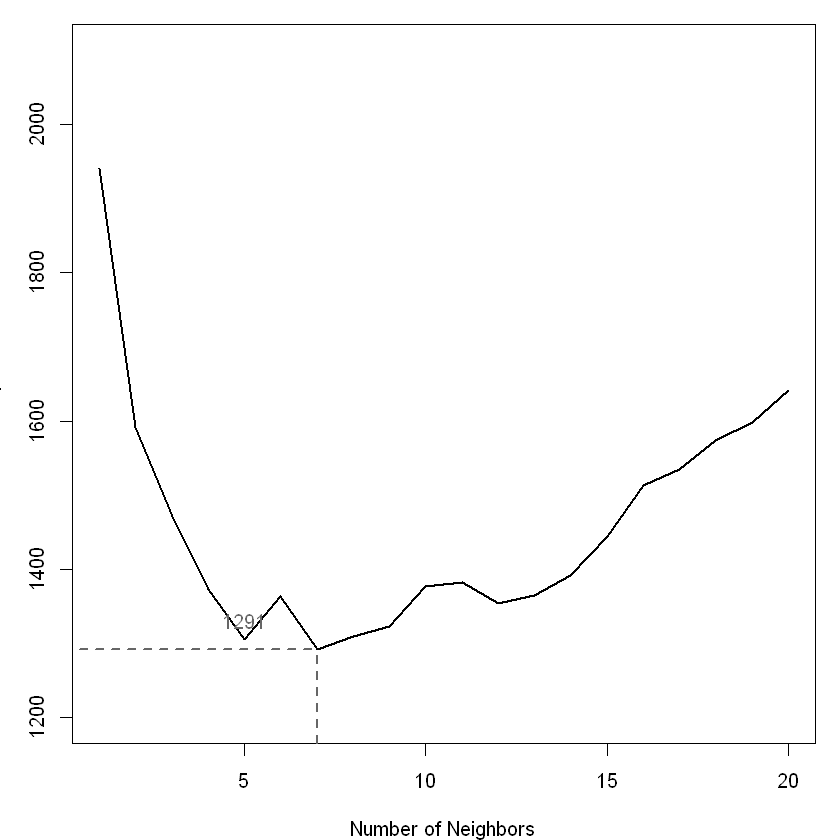

In [100]:
# Plot Sum of Squared Errors as function of k (figure 1.13)

#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
par(oldPar)
dev.off()


In [101]:
# Use value of 5 for nearest neighbor from cross-validation and apply to original training and test
estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

In [102]:
# Tally errors in preidctions

calcError(estXYk5, actualXY)

# values for k = 1 and k = 3 were 659 and 307
# value of k = 5 may not minimize value for online data because it was chosen without refernce to online data
# hence use cross validation (don't use online data in both selection of k and assessment of prediction

[1] 276

In [103]:
# Speed up Cross Validation Code, consider predXY()

predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                          trainSS)
  }
  
  estXY = lapply(closeXY, function(x)
    sapply(x[ , 2:3], 
           function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

# Recall findNN() returns all positions for training data, ordered according to their distance from the new observation's signal strength.
# Use first k positions but we have all locations so we can calculate estimates for all values of k; cumsum() helpful
# cumsum(x[1-:K])/(1:K) provides K means
# modify predXY() to return all K estiates and eliminate inner loop over k 


## Investigate number of angles to include in the trainig data; can use cross-validation to select parameter.
## Can be selected jointly via cross-valudation

## Ideas -

* KNN regression  
* Manhattan distance  
* creating a larger grid size e.g. instead of 15 by 26 in 1 meter increments positions do 5 meter increments. This would reduce the number of classes, while hopefully being granular enough for the purpose.   
* dimensionality reduction  
* scaling signals  

### 1.6 Results

### 1.7 Conclusion

### 1.8 References